# Bitcoin Price Prediction using Deep Learning Techniques

This notebook holds all experiments for the paper [insert name here](insert-link-here)

---

### Authors
 - Author1
 - Author2
 - Author3
    
### Date Created: 2024-04-22
### Date Last Modified: 2024-04-24

In [1]:
!nvidia-smi

Wed Apr 24 03:38:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8               6W /  60W |      8MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# We intend to shut down all warnings, and non-essential information in this notebook from TensorFlow
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from typing import List, Tuple, Dict

In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
# Checking the version of TensorFlow
print(tf.__version__)

2.15.0


## Dataset Preparation

In [6]:
dataframe = pd.read_csv('data/BTC-USD.csv', parse_dates=['Date'], index_col='Date')
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2014-09-17 to 2024-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3505 non-null   float64
 1   High       3505 non-null   float64
 2   Low        3505 non-null   float64
 3   Close      3505 non-null   float64
 4   Adj Close  3505 non-null   float64
 5   Volume     3505 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 191.7 KB


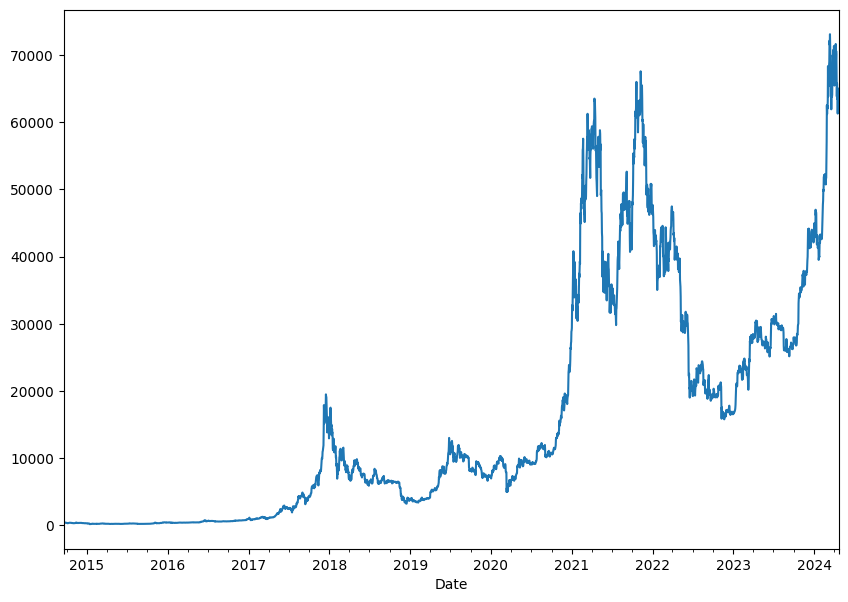

In [8]:
dataframe['Close'].plot(figsize=(10, 7));

In [9]:
# `btcc_prices` denotes the closing prices of BTC-USD.
btcc_prices = pd.DataFrame(dataframe["Close"].values, columns=["Price"], index=dataframe.index)
btcc_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [10]:
prices = btcc_prices['Price'].to_numpy()
prices

array([  457.334015,   424.440002,   394.79599 , ..., 63843.570313,
       64994.441406, 64773.386719])

In [11]:
# Normalizing the data
scaler = MinMaxScaler()

prices_normal = scaler.fit_transform(prices.reshape(-1, 1))
prices_normal

array([[0.00383005],
       [0.00337886],
       [0.00297225],
       ...,
       [0.87326138],
       [0.88904719],
       [0.88601512]])

In [12]:
# Create a plotting function
def plot_time_series(timestamps: List, values: List, format="-", start=0, end=None, title=None,
                     yLabel='BTC USD Close') -> None:
    """
    Plots a series of timestamps against values.

    Parameters
    ----------
    timestamps : list
        list of timestamp values
    values : list
        list of values across time
    format : str
        style of plot, default "."
    start : int
        starting index of the plot, ``start < len(timestamps)``
    end : int
        ending index of the plot, ``end < len(timestamps)``
    title : str
        label to show on plot of values
    """

    plt.plot(timestamps[start:end], values[start:end], format, label=title)
    plt.xlabel('Time')
    plt.ylabel(yLabel)
    if title:
        plt.legend(fontsize=14)
    plt.grid(True)


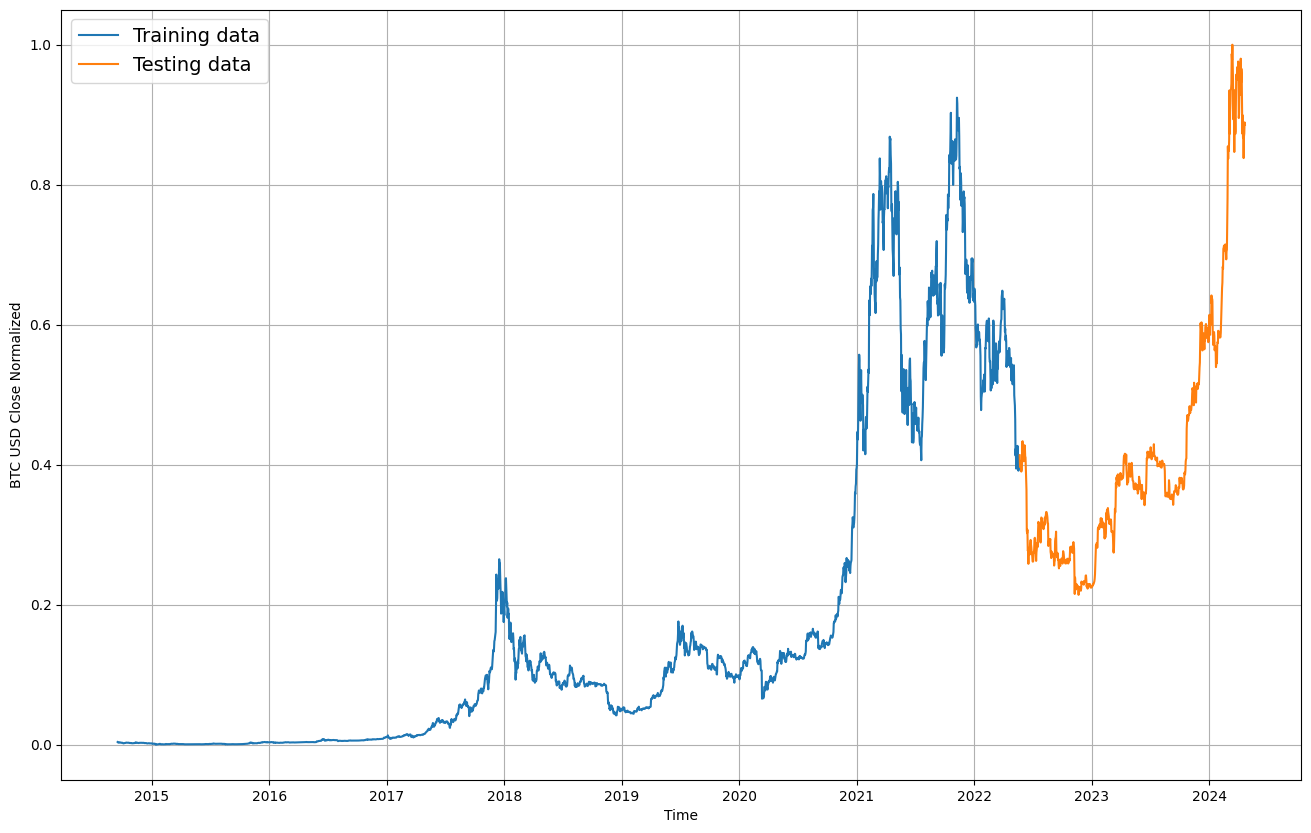

In [13]:
timestamps = btcc_prices.index.to_numpy()
training_data_len = int(.8 * len(btcc_prices))
test_data_len = len(btcc_prices) - training_data_len

plt.figure(figsize=(16, 10))
plot_time_series(timestamps=timestamps[:training_data_len], values=prices_normal[:training_data_len],
                 title="Training data")
plot_time_series(timestamps=timestamps[-test_data_len:], values=prices_normal[-test_data_len:], title="Testing data",
                 yLabel='BTC USD Close Normalized')

## Evaluation Metrics

In [14]:
def evaluate_pred(y_true: List, y_pred: List) -> Dict:
    """
    Performs various evaluation comparison functions on y_true labels and y_pred labels.

    Parameters
    ----------
    y_true : List
        true values
    y_pred : List
        predicted values

    Returns
    -------
    errors : dict
        dictionary containing the evaluation metrics, each metric is defined as a key-value pair where the key is the acronym for the metric in lowercase English.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    metric_results = {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
    }
    return metric_results

## Create Windows

In [15]:
WINDOW_SIZE = 7
HORIZON = 1

In [16]:
def get_labelled_windows(x: List, horizon=HORIZON) -> Tuple:
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [17]:
def make_windows(x: List, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array of sequential data into a 2D array of windowed data.

    E.g.
    x before windowing: [1, 2, 3, 4, 5, 6, 7, 8] size = (8),
    x after windowing: [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]] size = (3, 5)
    """

    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    windowed_array = x[window_indices]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return tf.squeeze(windows), tf.squeeze(labels)

In [18]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    E.g. if len(windows) = 100, len(labels) = 100 and test_split = 0.2
    80 windows and labels will go to the training set and 20 will go to the test set.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

## Prepare Utilities for Training

In [19]:
# Create a Checkpoint & EarlyStopping callback

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=0,
        save_best_only=True,
    )


def create_early_stopping(patience=3):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1,
    )

## Model Experiments

1. FNN (Feed-forward, Densely Connected Network)
2. LSTM (Long Short-Term Memory)
3. Bi-LSTM (Bidirectional Long Short-Term Memory)
4. GRU (Gated Recurrent Unit)
5. Bi-GRU (Bidirectional Gated Recurrent Unit)
6. Conv1D (1-Dimensional Convolutional Neural Network)
7. N-BEATS (Neural Basis Expansion Analysis Time Series Model)

Each model will be trained and validated on the following window sizes and horizons:
- Window Size: 7, Horizon: 1
- Window Size: 7, Horizon: 7
- Window Size: 30, Horizon: 1
- Window Size: 30, Horizon: 7
- Window Size: 90, Horizon: 1
- Window Size: 90, Horizon: 7
- Window Size: 90, Horizon: 30

In [87]:
all_res = {}

In [21]:
def fit_eval(
        model: tf.keras.models.Model,
        horizon=HORIZON,
        window=WINDOW_SIZE,
        epochs=100,
        fit_verbose=0,
) -> Tuple[List, Dict]:
    """
    Creates sliding windows for the given `WINDOW_SIZE` and `HORIZON`.
    Compiles and fits the model on the data for given number of `epochs`.
    Returns a dictionary of evaluation metrics.

    :param model: tf.keras.models.Model: the model to compile and fit
    :param horizon: int: the number of steps into the future to predict
    :param window: int: the number of timestamps to include in the input window
    :param epochs: int
    :param fit_verbose: int: level of verbosity of the fit method
    :return: a tuple containing the de-normalized predictions and a dictionary of evaluation metrics
    """

    # Clone the model to ensure a fresh copy is used
    model_clone = tf.keras.models.clone_model(model)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
        *make_windows(
            prices_normal,
            window_size=window,
            horizon=horizon,
        ))

    model_clone.build(input_shape=(None, window))

    model_clone.add(tf.keras.layers.Dense(horizon, activation="linear"))

    model_clone.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["mae", "mse", "mape"])

    history = model_clone.fit(
        train_windows,
        train_labels,
        epochs=epochs,
        batch_size=128,
        validation_data=(test_windows, test_labels),
        callbacks=[
            create_model_checkpoint(model_name=model_clone.name + "W" + str(window) + "H" + str(horizon)),
            create_early_stopping(patience=8)
        ],
        verbose=fit_verbose,
    )

    pd.DataFrame({"Validation MAPE": history.history['val_mape']}).plot(title="Validation MAPE", figsize=(8, 6))

    print("\n" + "-" * 20 + "\nEvaluating model on test data...")
    print(model_clone.evaluate(test_windows, test_labels, verbose=0))

    model_preds = model_clone.predict(test_windows)
    test_labels_inv = scaler.inverse_transform(tf.reshape(test_labels, shape=(-1, 1)))
    model_preds_inv = scaler.inverse_transform(tf.reshape(model_preds, shape=(-1, 1)))
    model_res = evaluate_pred(y_true=test_labels_inv, y_pred=model_preds_inv)

    return model_preds_inv, model_res


In [22]:
def save_model_plot(model: tf.keras.Model):
    """
    Saves the TF Model and a plot of the model to the filesystem.
    :param model:
    :return:
    """
    tf.keras.saving.save_model(model, os.path.join("model_experiments", model.name))
    tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        to_file=os.path.join("model_experiments", model.name + ".png")
    )
    print(f"Model saved to: {os.path.join('model_experiments', model.name, '')}")
    print(f"Model plot saved to: {os.path.join('model_experiments', model.name + '.png')}")

### FNN (Feed-forward, Densely Connected Network)

In [23]:
model_fnn = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
], name="FNN")

#### FNN - Window Size 7, Horizon 1

I0000 00:00:1713910127.691783  232428 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Restoring model weights from the end of the best epoch: 31.
Epoch 39: early stopping

--------------------
Evaluating model on test data...
[0.008623669855296612, 0.008623669855296612, 0.0001945727999554947, 1.9961479902267456]
22/22 [==============================] - 0s 973us/step


{'mae': 628.71216, 'mse': 1034192.94, 'rmse': 628.71216, 'mape': 1.9828631}

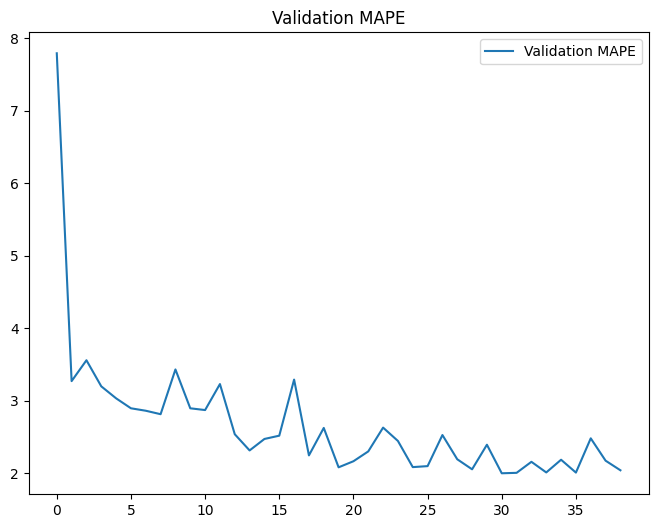

In [24]:
model_fnn_w7h1_preds_inv, model_fnn_w7h1_res = fit_eval(model_fnn, horizon=1, window=7)
model_fnn_w7h1_res

#### FNN - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 58.
Epoch 66: early stopping

--------------------
Evaluating model on test data...
[0.016935091465711594, 0.016935091465711594, 0.0007291542133316398, 4.038120269775391]
22/22 [==============================] - 0s 897us/step


{'mae': 1234.6597, 'mse': 3875599.0, 'rmse': 1234.6597, 'mape': 4.0107226}

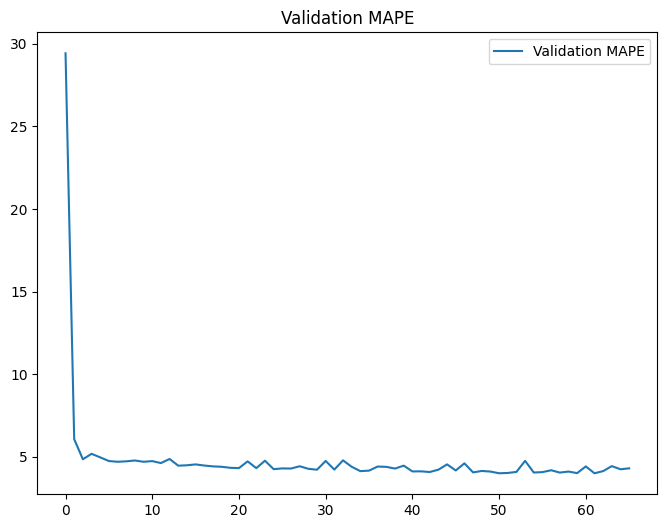

In [25]:
model_fnn_w7h7_preds_inv, model_fnn_w7h7_res = fit_eval(model_fnn, horizon=7, window=7)
model_fnn_w7h7_res

#### FNN - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 72.
Epoch 80: early stopping

--------------------
Evaluating model on test data...
[0.008913458324968815, 0.008913458324968815, 0.00020259982557035983, 2.136068820953369]
22/22 [==============================] - 0s 850us/step


{'mae': 649.8393, 'mse': 1076858.0, 'rmse': 649.8393, 'mape': 2.121557}

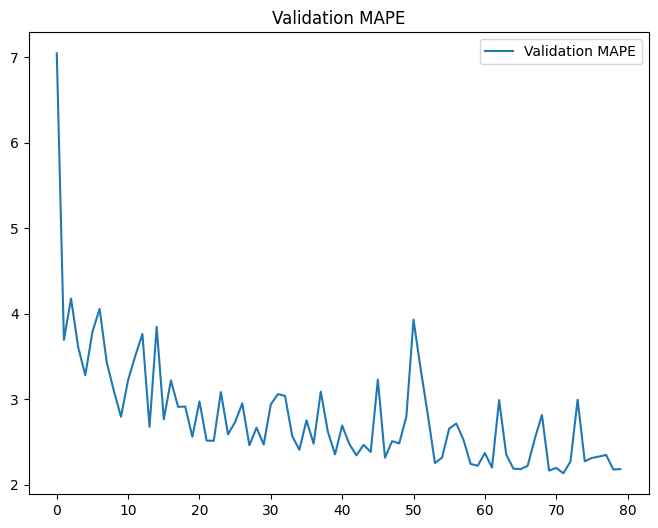

In [26]:
model_fnn_w30h1_preds_inv, model_fnn_w30h1_res = fit_eval(model_fnn, horizon=1, window=30)
model_fnn_w30h1_res

#### FNN - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 57.
Epoch 65: early stopping

--------------------
Evaluating model on test data...
[0.017695367336273193, 0.017695367336273193, 0.0007806972716934979, 4.226470470428467]
22/22 [==============================] - 0s 864us/step


{'mae': 1290.0876, 'mse': 4149560.0, 'rmse': 1290.0876, 'mape': 4.197785}

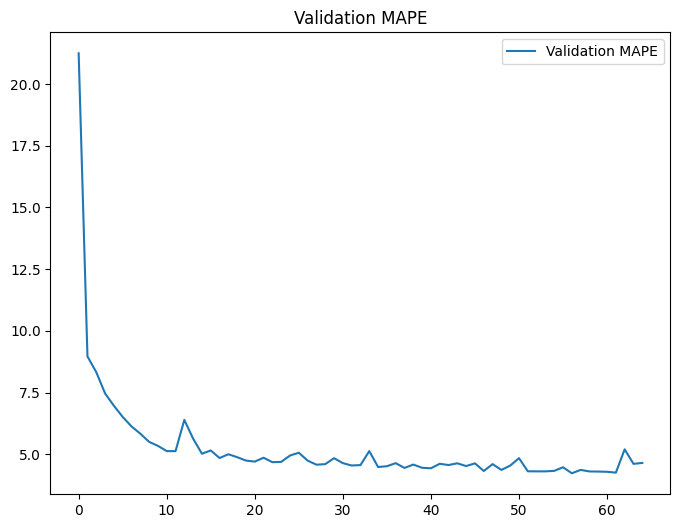

In [27]:
model_fnn_w30h7_preds_inv, model_fnn_w30h7_res = fit_eval(model_fnn, horizon=7, window=30)
model_fnn_w30h7_res

#### FNN - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 17.
Epoch 25: early stopping

--------------------
Evaluating model on test data...
[0.014069859869778156, 0.014069859869778156, 0.0004510197904892266, 3.417332410812378]
22/22 [==============================] - 0s 871us/step


{'mae': 1025.7687, 'mse': 2397259.0, 'rmse': 1025.7687, 'mape': 3.3937867}

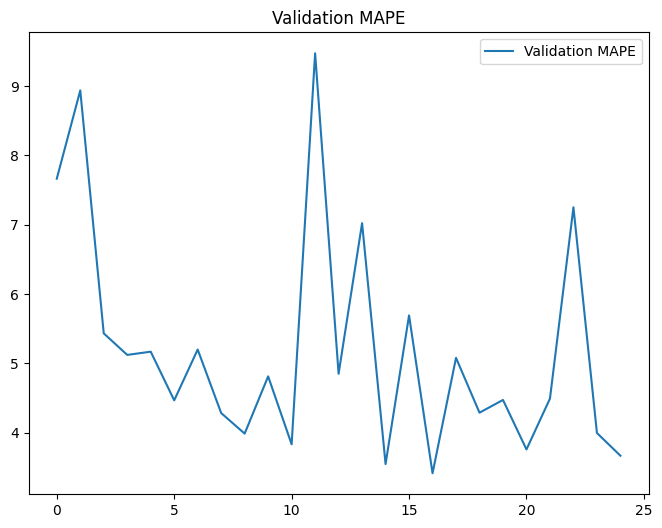

In [28]:
model_fnn_w90h1_preds_inv, model_fnn_w90h1_res = fit_eval(model_fnn, horizon=1, window=90)
model_fnn_w90h1_res

#### FNN - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 42.
Epoch 50: early stopping

--------------------
Evaluating model on test data...
[0.021626682952046394, 0.021626682952046394, 0.0010248617036268115, 5.2961812019348145]
22/22 [==============================] - 0s 851us/step


{'mae': 1576.7019, 'mse': 5447342.0, 'rmse': 1576.7019, 'mape': 5.2594213}

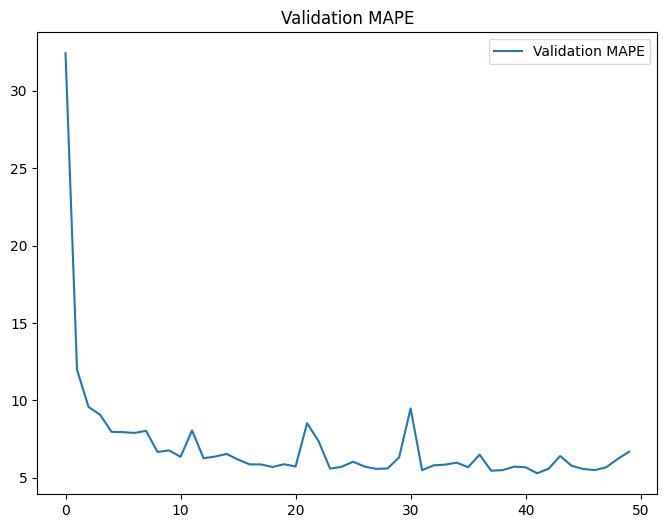

In [29]:
model_fnn_w90h7_preds_inv, model_fnn_w90h7_res = fit_eval(model_fnn, horizon=7, window=90)
model_fnn_w90h7_res

#### FNN - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 34.
Epoch 42: early stopping

--------------------
Evaluating model on test data...
[0.03993231803178787, 0.03993231803178787, 0.0038932424504309893, 9.555553436279297]
22/22 [==============================] - 0s 1ms/step


{'mae': 2911.2815, 'mse': 20693352.0, 'rmse': 2911.2815, 'mape': 9.490272}

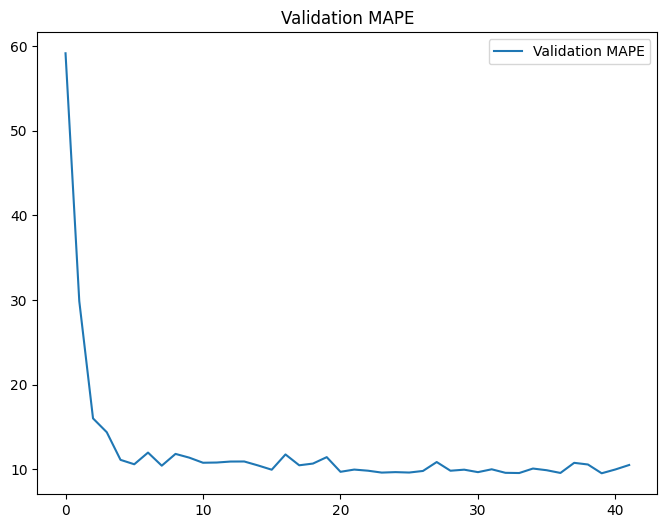

In [30]:
model_fnn_w90h30_preds_inv, model_fnn_w90h30_res = fit_eval(model_fnn, horizon=30, window=90)
model_fnn_w90h30_res

In [31]:
# Compile all results together
model_fnn_res = {
    "W7H1": model_fnn_w7h1_res,
    "W7H7": model_fnn_w7h7_res,
    "W30H1": model_fnn_w30h1_res,
    "W30H7": model_fnn_w30h7_res,
    "W90H1": model_fnn_w90h1_res,
    "W90H7": model_fnn_w90h7_res,
    "W90H30": model_fnn_w90h30_res,
}

In [88]:
all_res["FNN"] = model_fnn_res

### Conv1D (Convolutional Neural Network)

In [33]:
model_conv1d = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(32, kernel_size=8, padding='same', strides=2),
    tf.keras.layers.GlobalMaxPool1D(),
], name="Conv1D")

#### Conv1D - Window - 7 , Horizon - 1

Restoring model weights from the end of the best epoch: 40.
Epoch 48: early stopping

--------------------
Evaluating model on test data...
[0.008215852081775665, 0.008215852081775665, 0.00018492626259103417, 1.9272679090499878]
22/22 [==============================] - 0s 866us/step


{'mae': 598.98, 'mse': 982919.75, 'rmse': 598.98, 'mape': 1.91435}

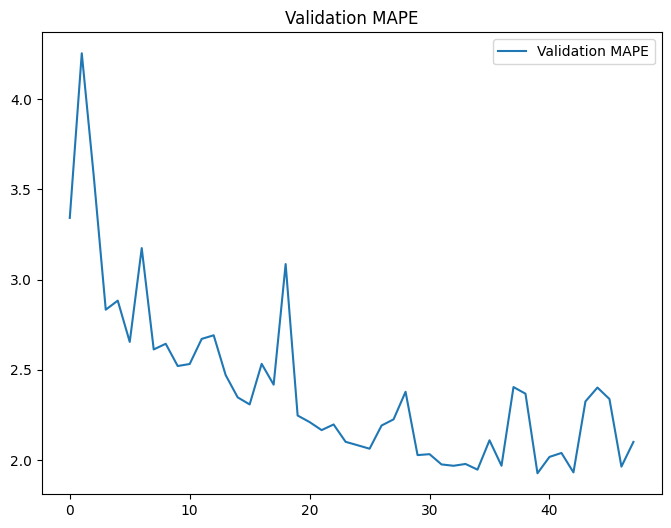

In [34]:
model_conv1d_w7h1_preds_inv, model_conv1d_w7h1_res = fit_eval(model_conv1d, window=7, horizon=1)
model_conv1d_w7h1_res

#### Conv1D - Window - 7 , Horizon - 7

Restoring model weights from the end of the best epoch: 78.
Epoch 86: early stopping

--------------------
Evaluating model on test data...
[0.016558384522795677, 0.016558384522795677, 0.0007173894555307925, 3.9431700706481934]
22/22 [==============================] - 0s 822us/step


{'mae': 1207.1956, 'mse': 3813066.2, 'rmse': 1207.1956, 'mape': 3.9164662}

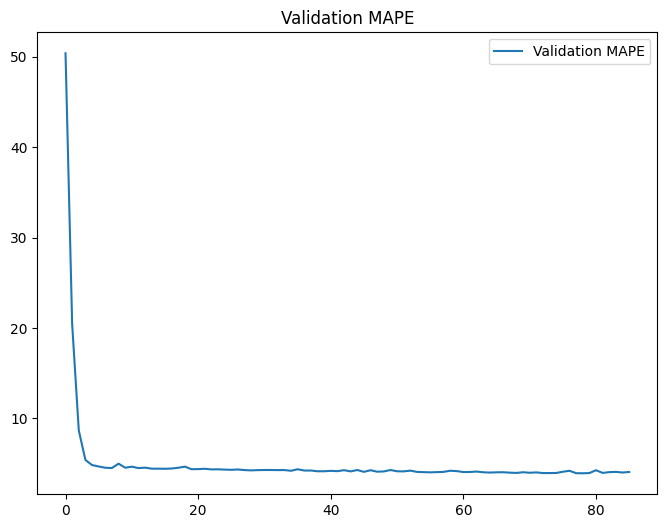

In [35]:
model_conv1d_w7h7_preds_inv, model_conv1d_w7h7_res = fit_eval(model_conv1d, window=7, horizon=7)
model_conv1d_w7h7_res

#### Conv1D - Window - 30, Horizon - 1

Restoring model weights from the end of the best epoch: 55.
Epoch 63: early stopping

--------------------
Evaluating model on test data...
[0.008502972312271595, 0.008502972312271595, 0.00019312254153192043, 2.000505208969116]
22/22 [==============================] - 0s 943us/step


{'mae': 619.9126, 'mse': 1026484.7, 'rmse': 619.9126, 'mape': 1.9871054}

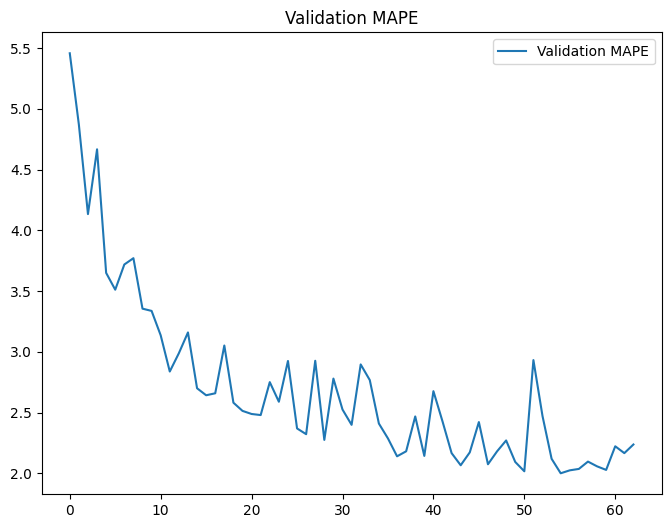

In [36]:
model_conv1d_w30h1_preds_inv, model_conv1d_w30h1_res = fit_eval(model_conv1d, window=30, horizon=1)
model_conv1d_w30h1_res

#### Conv1D - Window - 30 Horizon - 7

Restoring model weights from the end of the best epoch: 42.
Epoch 50: early stopping

--------------------
Evaluating model on test data...
[0.017572611570358276, 0.017572611570358276, 0.0007770095835439861, 4.186757564544678]
22/22 [==============================] - 0s 964us/step


{'mae': 1281.1383, 'mse': 4129959.2, 'rmse': 1281.1383, 'mape': 4.1584315}

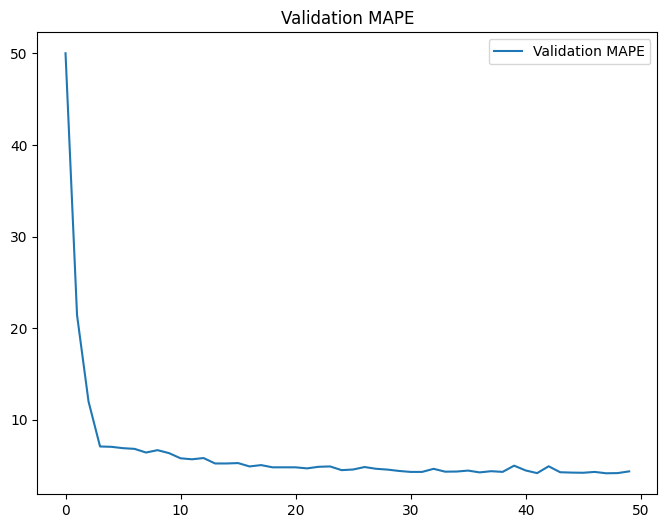

In [37]:
model_conv1d_w30h7_preds_inv, model_conv1d_w30h7_res = fit_eval(model_conv1d, window=30, horizon=7)
model_conv1d_w30h7_res

#### Conv1D - Window - 90 Horizon - 1

Restoring model weights from the end of the best epoch: 42.
Epoch 50: early stopping

--------------------
Evaluating model on test data...
[0.008632524870336056, 0.008632524870336056, 0.00020434671023394912, 2.041149377822876]
22/22 [==============================] - 0s 868us/step


{'mae': 629.35767, 'mse': 1086143.5, 'rmse': 629.35767, 'mape': 2.0273597}

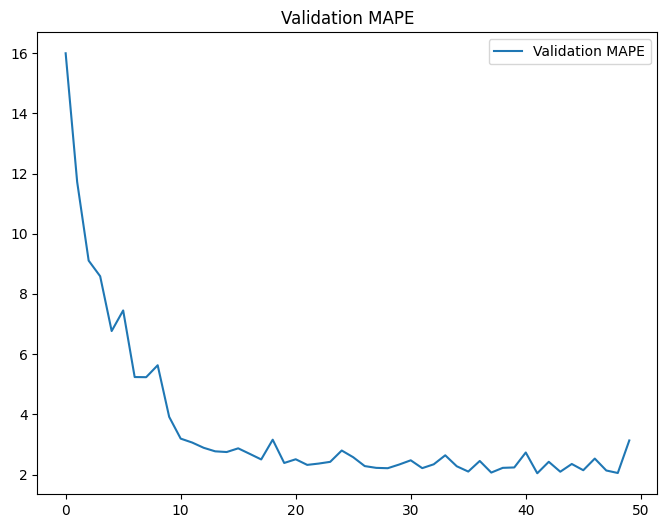

In [38]:
model_conv1d_w90h1_preds_inv, model_conv1d_w90h1_res = fit_eval(model_conv1d, window=90, horizon=1)
model_conv1d_w90h1_res

#### Conv1D - Window - 90 Horzion - 7

Restoring model weights from the end of the best epoch: 50.
Epoch 58: early stopping

--------------------
Evaluating model on test data...
[0.01745469681918621, 0.01745469681918621, 0.00080367352347821, 4.101595878601074]
22/22 [==============================] - 0s 959us/step


{'mae': 1272.5415, 'mse': 4271683.5, 'rmse': 1272.5415, 'mape': 4.074076}

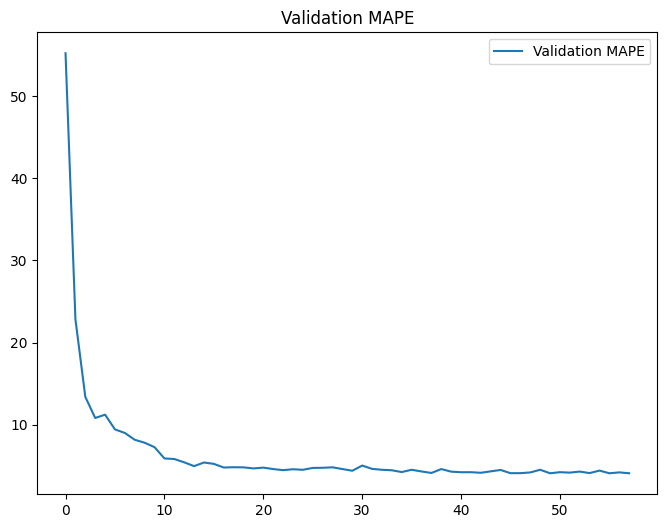

In [39]:
model_conv1d_w90h7_preds_inv, model_conv1d_w90h7_res = fit_eval(model_conv1d, window=90, horizon=7)
model_conv1d_w90h7_res

#### Conv1D - Window - 90 Horizon - 30

Restoring model weights from the end of the best epoch: 43.
Epoch 51: early stopping

--------------------
Evaluating model on test data...
[0.035196010023355484, 0.035196010023355484, 0.0032081645913422108, 8.4078950881958]
22/22 [==============================] - 0s 796us/step


{'mae': 2565.979, 'mse': 17052028.0, 'rmse': 2565.979, 'mape': 8.3508215}

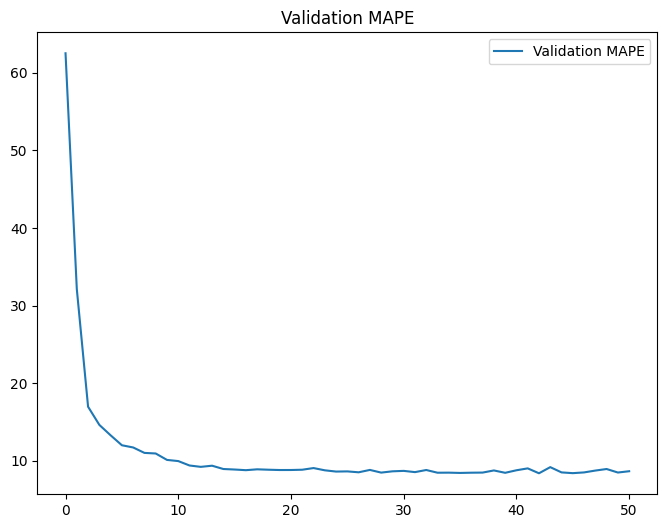

In [40]:
model_conv1d_w90h30_preds_inv, model_conv1d_w90h30_res = fit_eval(model_conv1d, window=90, horizon=30)
model_conv1d_w90h30_res

In [41]:
model_conv1d_res = {
    "W7H1": model_conv1d_w7h1_res,
    "W7H7": model_conv1d_w7h7_res,
    "W30H1": model_conv1d_w30h1_res,
    "W30H7": model_conv1d_w30h7_res,
    "W90H1": model_conv1d_w90h1_res,
    "W90H7": model_conv1d_w90h7_res,
    "W90H30": model_conv1d_w90h30_res,
}

In [89]:
all_res["Conv1D"] = model_conv1d_res

### LSTM (Long Short Term Memory)

In [43]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.LSTM(128, activation="relu"),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.LSTM(128, activation="relu"),
], name="LSTM")

#### LSTM - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 54.
Epoch 62: early stopping

--------------------
Evaluating model on test data...
[0.00911716278642416, 0.00911716278642416, 0.00021299351647030562, 2.146392583847046]
22/22 [==============================] - 0s 1ms/step


{'mae': 664.6904, 'mse': 1132102.6, 'rmse': 664.6904, 'mape': 2.1320095}

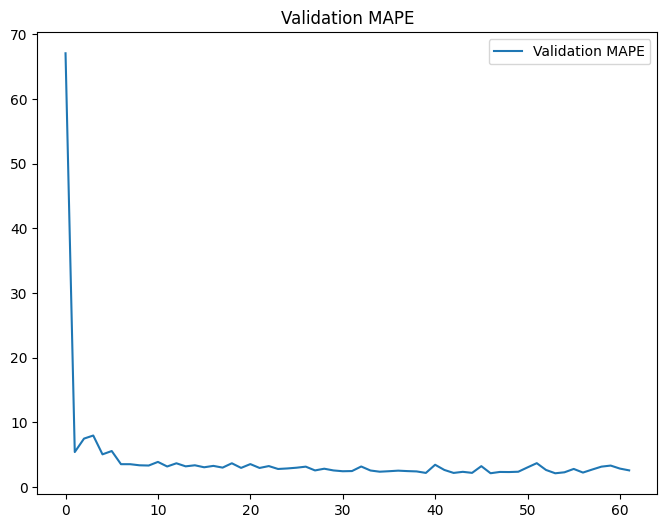

In [44]:
model_lstm_w7h1_preds_inv, model_lstm_w7h1_res = fit_eval(model_lstm, horizon=1, window=7)
model_lstm_w7h1_res

#### LSTM - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 52.
Epoch 60: early stopping

--------------------
Evaluating model on test data...
[0.01804301328957081, 0.01804301328957081, 0.0008389216382056475, 4.22050666809082]
22/22 [==============================] - 0s 1ms/step


{'mae': 1315.4331, 'mse': 4459034.5, 'rmse': 1315.4331, 'mape': 4.1923018}

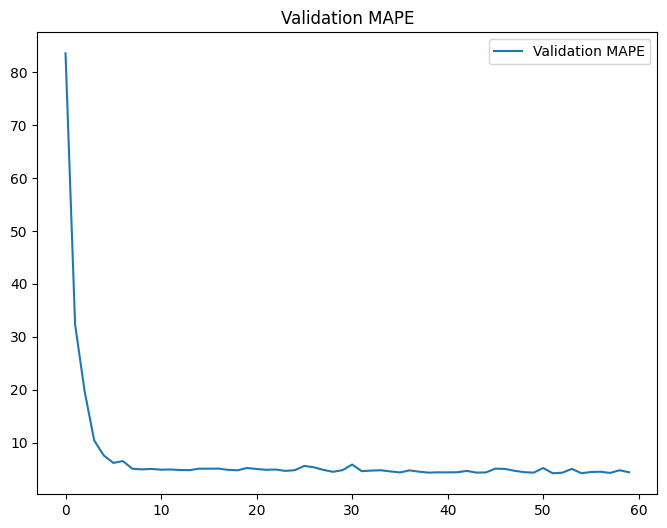

In [45]:
model_lstm_w7h7_preds_inv, model_lstm_w7h7_res = fit_eval(model_lstm, horizon=7, window=7)
model_lstm_w7h7_res

#### LSTM - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 68.
Epoch 76: early stopping

--------------------
Evaluating model on test data...
[0.009695124812424183, 0.009695124812424183, 0.00023146286548580974, 2.3143553733825684]
22/22 [==============================] - 0s 1ms/step


{'mae': 706.82684, 'mse': 1230270.8, 'rmse': 706.82684, 'mape': 2.2986097}

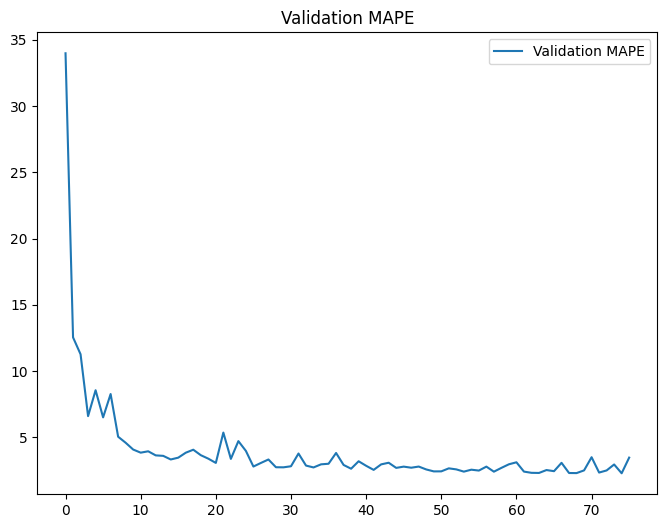

In [46]:
model_lstm_w30h1_preds_inv, model_lstm_w30h1_res = fit_eval(model_lstm, horizon=1, window=30)
model_lstm_w30h1_res

#### LSTM - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 21.
Epoch 29: early stopping

--------------------
Evaluating model on test data...
[0.019883379340171814, 0.019883379340171814, 0.0009254769538529217, 4.789875507354736]
22/22 [==============================] - 0s 2ms/step


{'mae': 1449.6056, 'mse': 4919092.0, 'rmse': 1449.6056, 'mape': 4.757096}

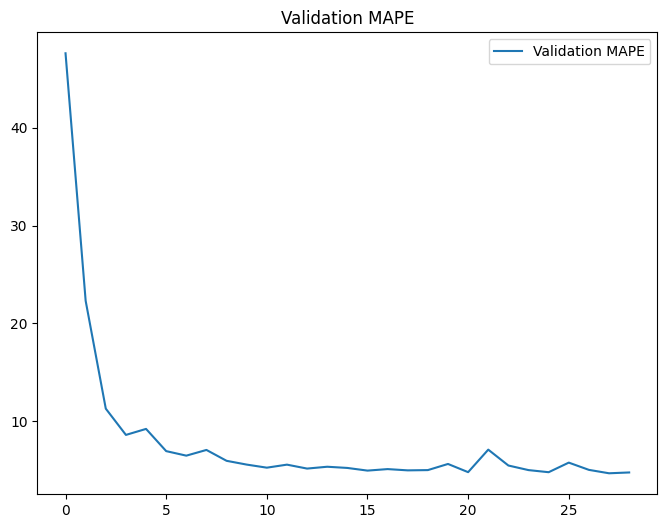

In [47]:
model_lstm_w30h7_preds_inv, model_lstm_w30h7_res = fit_eval(model_lstm, horizon=7, window=30)
model_lstm_w30h7_res

#### LSTM - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 56.
Epoch 64: early stopping

--------------------
Evaluating model on test data...
[0.011910861358046532, 0.011910861358046532, 0.0003279037482570857, 2.864065408706665]
22/22 [==============================] - 0s 1ms/step


{'mae': 868.36615, 'mse': 1742873.1, 'rmse': 868.36615, 'mape': 2.8444192}

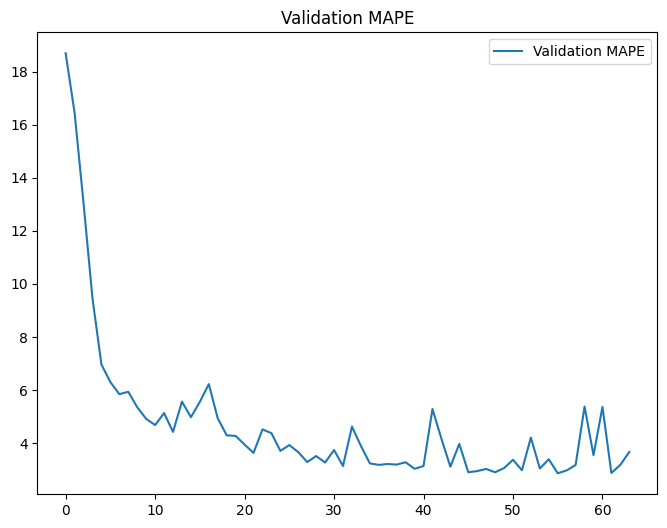

In [48]:
model_lstm_w90h1_preds_inv, model_lstm_w90h1_res = fit_eval(model_lstm, horizon=1, window=90)
model_lstm_w90h1_res

#### LSTM - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 18.
Epoch 26: early stopping

--------------------
Evaluating model on test data...
[0.015227695927023888, 0.015227695927023888, 0.0005050859763287008, 3.6857123374938965]
22/22 [==============================] - 0s 1ms/step


{'mae': 1110.1814, 'mse': 2684632.0, 'rmse': 1110.1814, 'mape': 3.6604128}

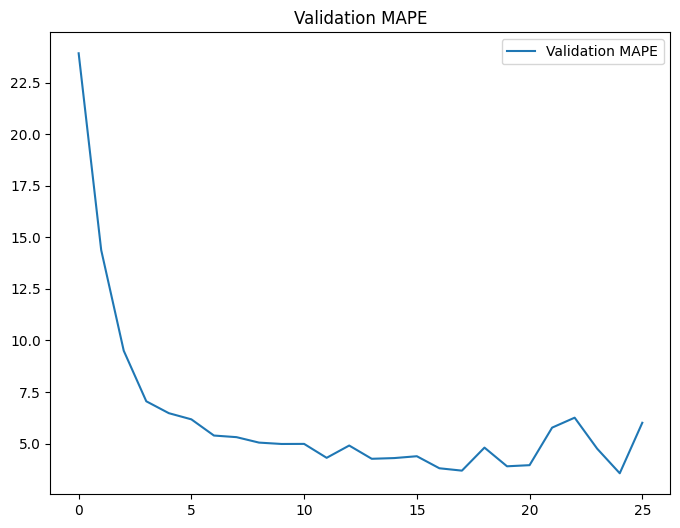

In [49]:
model_lstm_w90h7_preds_inv, model_lstm_w90h7_res = fit_eval(model_lstm, horizon=1, window=90)
model_lstm_w90h7_res

#### LSTM - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 17.
Epoch 25: early stopping

--------------------
Evaluating model on test data...
[0.043251439929008484, 0.043251439929008484, 0.004625474568456411, 10.207356452941895]
22/22 [==============================] - 0s 1ms/step


{'mae': 3153.2637, 'mse': 24585308.0, 'rmse': 3153.2637, 'mape': 10.138274}

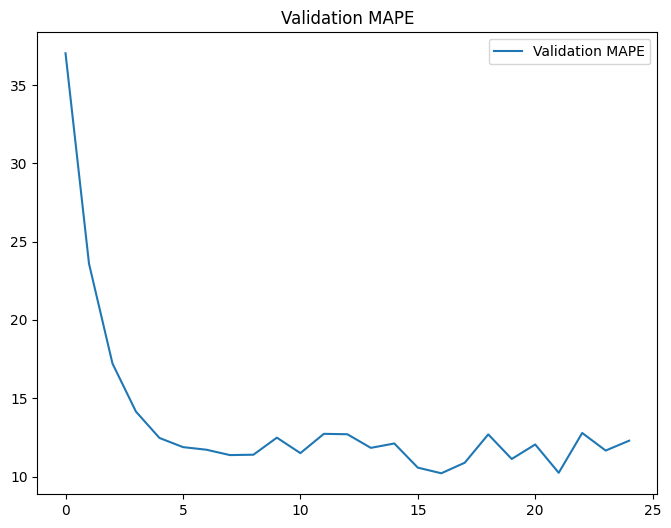

In [50]:
model_lstm_w90h30_preds_inv, model_lstm_w90h30_res = fit_eval(model_lstm, horizon=30, window=90)
model_lstm_w90h30_res

In [52]:
model_lstm_res = {
    "W7H1": model_lstm_w7h1_res,
    "W7H7": model_lstm_w7h7_res,
    "W30H1": model_lstm_w30h1_res,
    "W30H7": model_lstm_w30h7_res,
    "W90H1": model_lstm_w90h1_res,
    "W90H7": model_lstm_w90h7_res,
    "W90H30": model_lstm_w90h30_res,
}

In [90]:
all_res["LSTM"] = model_lstm_res

### Bidirectional LSTM

In [51]:
model_bi_lstm = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="linear")),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="linear")),
], name="BiLSTM")

#### BiLSTM - Window Size 7, Horizon 1


Restoring model weights from the end of the best epoch: 16.
Epoch 24: early stopping

--------------------
Evaluating model on test data...
[0.008773952722549438, 0.008773952722549438, 0.00020310729451011866, 2.066047191619873]
22/22 [==============================] - 0s 2ms/step


{'mae': 639.6686, 'mse': 1079555.2, 'rmse': 639.6686, 'mape': 2.0522015}

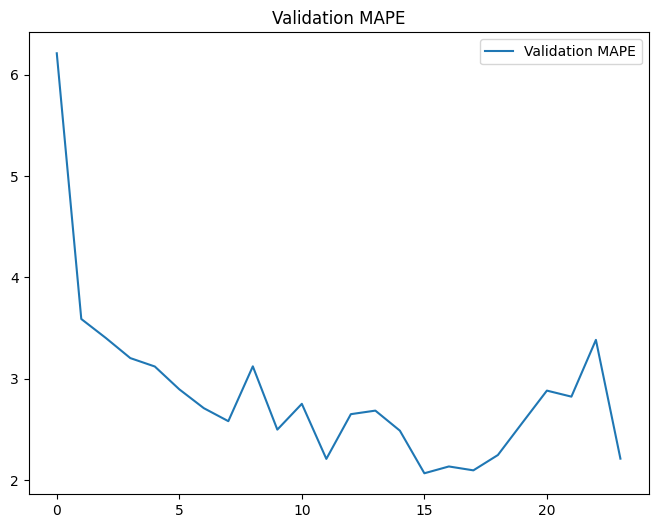

In [54]:
model_bi_lstm_w7h1_preds_inv, model_bi_lstm_w7h1_res = fit_eval(model_bi_lstm, horizon=1, window=7)
model_bi_lstm_w7h1_res

#### BiLSTM - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 35.
Epoch 43: early stopping

--------------------
Evaluating model on test data...
[0.01694284938275814, 0.01694284938275814, 0.0007535479380749166, 3.9963619709014893]
22/22 [==============================] - 0s 2ms/step


{'mae': 1235.2255, 'mse': 4005256.0, 'rmse': 1235.2255, 'mape': 3.969484}

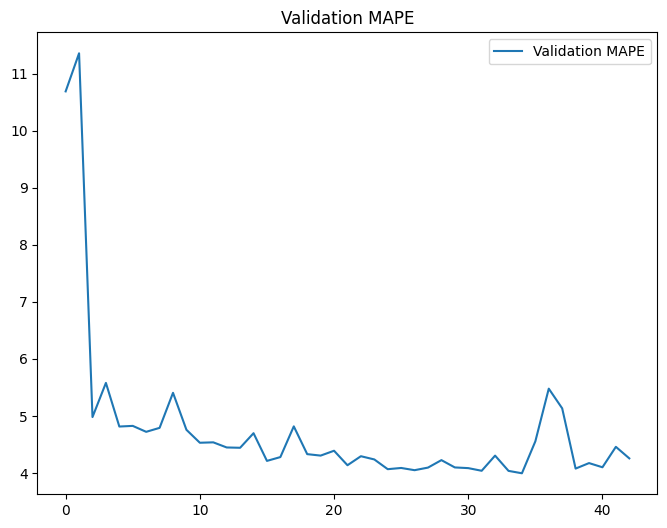

In [55]:
model_bi_lstm_w7h7_preds_inv, model_bi_lstm_w7h7_res = fit_eval(model_bi_lstm, horizon=7, window=7)
model_bi_lstm_w7h7_res

#### BiLSTM - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 24.
Epoch 32: early stopping

--------------------
Evaluating model on test data...
[0.009528692811727524, 0.009528692811727524, 0.00022882172197569162, 2.247309923171997]
22/22 [==============================] - 0s 2ms/step


{'mae': 694.69324, 'mse': 1216232.6, 'rmse': 694.69324, 'mape': 2.2322214}

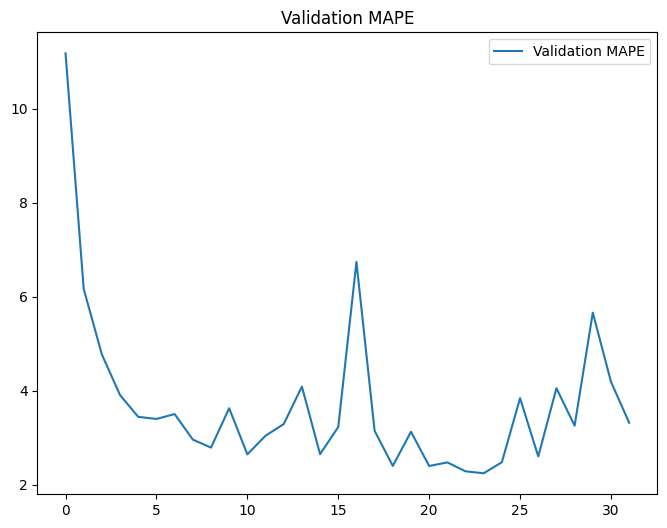

In [56]:
model_bi_lstm_w30h1_preds_inv, model_bi_lstm_w30h1_res = fit_eval(model_bi_lstm, horizon=1, window=30)
model_bi_lstm_w30h1_res

#### BiLSTM - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 19.
Epoch 27: early stopping

--------------------
Evaluating model on test data...
[0.018122315406799316, 0.018122315406799316, 0.0008371546282432973, 4.288872718811035]
22/22 [==============================] - 0s 2ms/step


{'mae': 1321.2148, 'mse': 4449641.5, 'rmse': 1321.2148, 'mape': 4.259908}

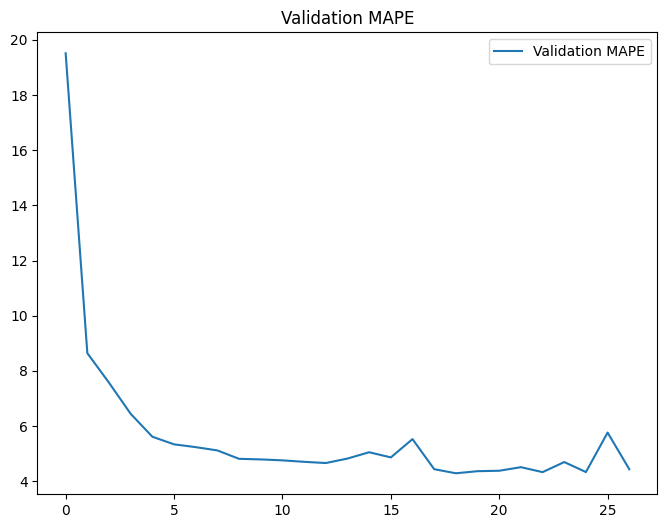

In [57]:
model_bi_lstm_w30h7_preds_inv, model_bi_lstm_w30h7_res = fit_eval(model_bi_lstm, horizon=7, window=30)
model_bi_lstm_w30h7_res

#### BiLSTM - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 62.
Epoch 70: early stopping

--------------------
Evaluating model on test data...
[0.009870924986898899, 0.009870924986898899, 0.0002444926940370351, 2.3214306831359863]
22/22 [==============================] - 0s 2ms/step


{'mae': 719.6436, 'mse': 1299526.8, 'rmse': 719.6436, 'mape': 2.3057802}

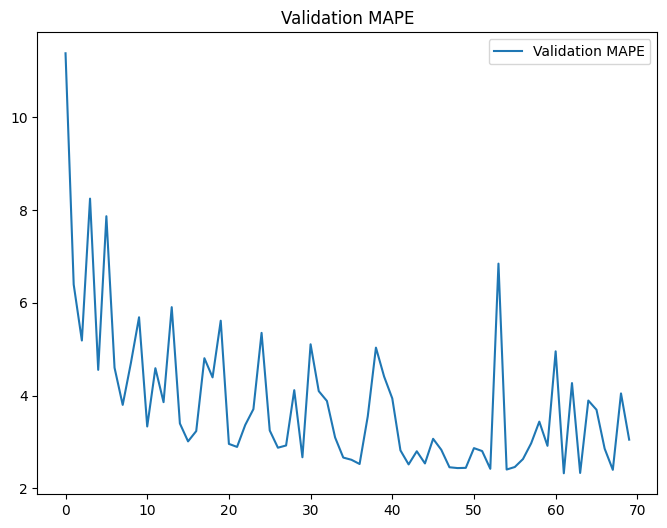

In [58]:
model_bi_lstm_w90h1_preds_inv, model_bi_lstm_w90h1_res = fit_eval(model_bi_lstm, horizon=1, window=90)
model_bi_lstm_w90h1_res

#### BiLSTM - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 20.
Epoch 28: early stopping

--------------------
Evaluating model on test data...
[0.020554788410663605, 0.020554788410663605, 0.0010079919593408704, 4.949638843536377]
22/22 [==============================] - 0s 2ms/step


{'mae': 1498.5549, 'mse': 5357676.0, 'rmse': 1498.5549, 'mape': 4.9156814}

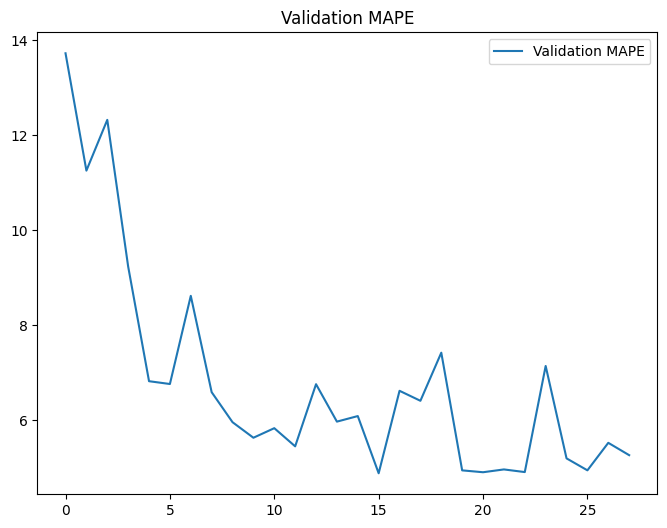

In [59]:
model_bi_lstm_w90h7_preds_inv, model_bi_lstm_w90h7_res = fit_eval(model_bi_lstm, horizon=7, window=90)
model_bi_lstm_w90h7_res

#### BiLSTM - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping

--------------------
Evaluating model on test data...
[0.041677653789520264, 0.041677653789520264, 0.004182913806289434, 10.112762451171875]
22/22 [==============================] - 0s 1ms/step


{'mae': 3038.526, 'mse': 22233010.0, 'rmse': 3038.526, 'mape': 10.042293}

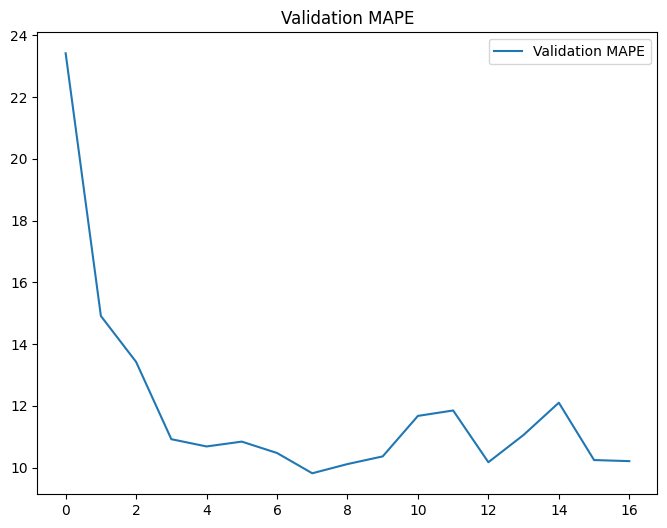

In [60]:
model_bi_lstm_w90h30_preds_inv, model_bi_lstm_w90h30_res = fit_eval(model_bi_lstm, horizon=30, window=90)
model_bi_lstm_w90h30_res

In [61]:
model_bi_lstm_res = {
    "W7H1": model_bi_lstm_w7h1_res,
    "W7H7": model_bi_lstm_w7h7_res,
    "W30H1": model_bi_lstm_w30h1_res,
    "W30H7": model_bi_lstm_w30h7_res,
    "W90H1": model_bi_lstm_w90h1_res,
    "W90H7": model_bi_lstm_w90h7_res,
    "W90H30": model_bi_lstm_w90h30_res,
}

In [91]:
all_res["BiLSTM"] = model_bi_lstm_res

### GRU (Gated Recurrent Unit)

In [63]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.GRU(128, activation="linear"),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.GRU(128, activation="linear")
], name="GRU")

#### GRU - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 49.
Epoch 57: early stopping

--------------------
Evaluating model on test data...
[0.008113817311823368, 0.008113817311823368, 0.00018285165424458683, 1.9012670516967773]
22/22 [==============================] - 0s 1ms/step


{'mae': 591.541, 'mse': 971892.75, 'rmse': 591.541, 'mape': 1.8885362}

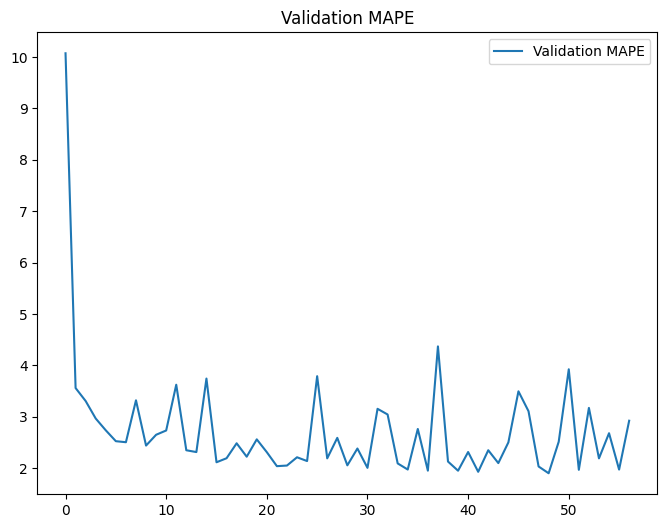

In [64]:
model_gru_w7h1_preds_inv, model_gru_w7h1_res = fit_eval(model_gru, horizon=1, window=7)
model_gru_w7h1_res

#### GRU - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 22.
Epoch 30: early stopping

--------------------
Evaluating model on test data...
[0.017214255407452583, 0.017214255407452583, 0.0007703129667788744, 4.072227954864502]
22/22 [==============================] - 0s 1ms/step


{'mae': 1255.0122, 'mse': 4094365.5, 'rmse': 1255.0122, 'mape': 4.0447803}

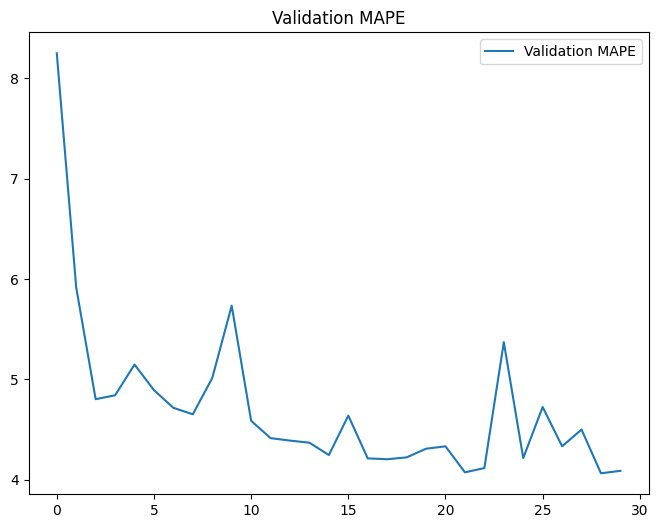

In [65]:
model_gru_w7h7_preds_inv, model_gru_w7h7_res = fit_eval(model_gru, horizon=7, window=7)
model_gru_w7h7_res

#### GRU - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 19.
Epoch 27: early stopping

--------------------
Evaluating model on test data...
[0.009432725608348846, 0.009432725608348846, 0.00022249414178077132, 2.2518789768218994]
22/22 [==============================] - 0s 2ms/step


{'mae': 687.69666, 'mse': 1182600.5, 'rmse': 687.69666, 'mape': 2.2366223}

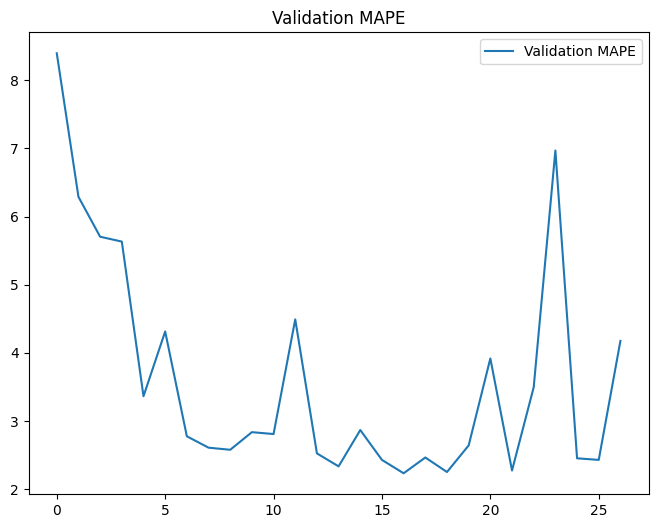

In [66]:
model_gru_w30h1_preds_inv, model_gru_w30h1_res = fit_eval(model_gru, horizon=1, window=30)
model_gru_w30h1_res

#### GRU - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 37.
Epoch 45: early stopping

--------------------
Evaluating model on test data...
[0.017278701066970825, 0.017278701066970825, 0.0007557274657301605, 4.124083518981934]
22/22 [==============================] - 0s 2ms/step


{'mae': 1259.7106, 'mse': 4016840.0, 'rmse': 1259.7106, 'mape': 4.09614}

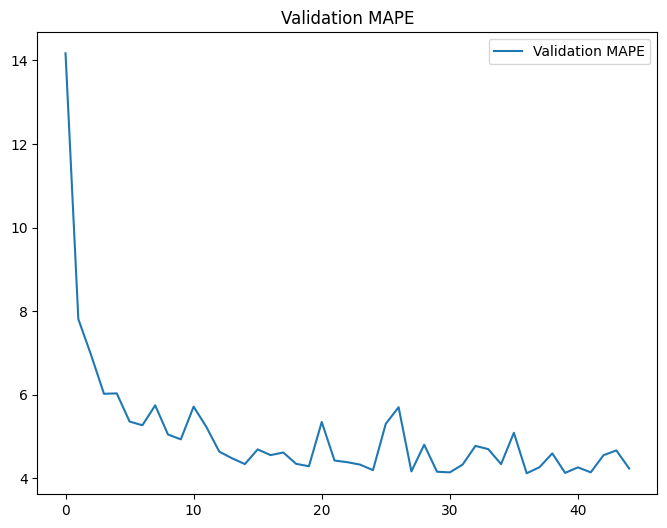

In [67]:
model_gru_w30h7_preds_inv, model_gru_w30h7_res = fit_eval(model_gru, horizon=7, window=30)
model_gru_w30h7_res

#### GRU - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 34.
Epoch 42: early stopping

--------------------
Evaluating model on test data...
[0.010792352259159088, 0.010792352259159088, 0.00027189089450985193, 2.5865814685821533]
22/22 [==============================] - 0s 2ms/step


{'mae': 786.8206, 'mse': 1445153.8, 'rmse': 786.8206, 'mape': 2.5690935}

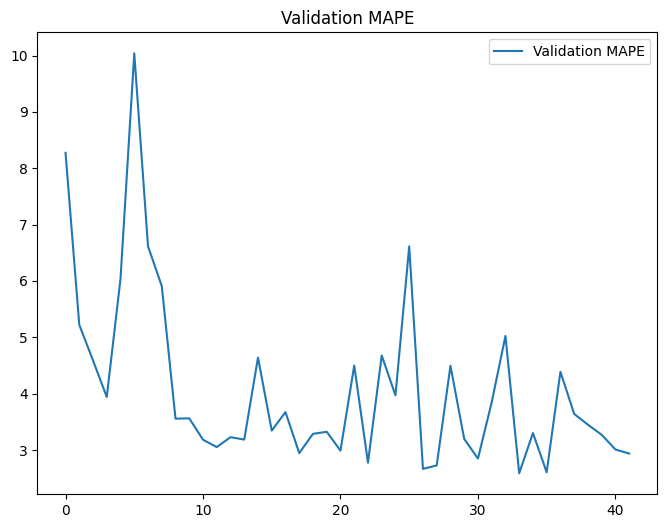

In [68]:
model_gru_w90h1_preds_inv, model_gru_w90h1_res = fit_eval(model_gru, horizon=1, window=90)
model_gru_w90h1_res

#### GRU - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 24.
Epoch 32: early stopping

--------------------
Evaluating model on test data...
[0.02005932852625847, 0.02005932852625847, 0.0009399268892593682, 4.825421333312988]
22/22 [==============================] - 0s 2ms/step


{'mae': 1462.4335, 'mse': 4995896.5, 'rmse': 1462.4335, 'mape': 4.792447}

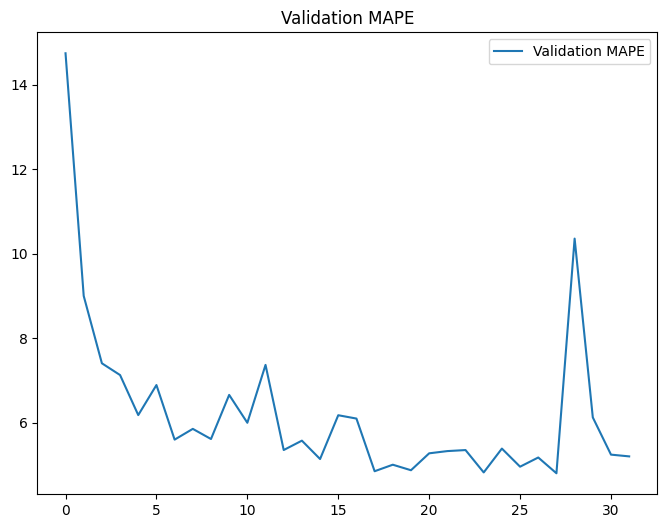

In [69]:
model_gru_w90h7_preds_inv, model_gru_w90h7_res = fit_eval(model_gru, horizon=7, window=90)
model_gru_w90h7_res

#### GRU - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 20.
Epoch 28: early stopping

--------------------
Evaluating model on test data...
[0.04009466618299484, 0.04009466618299484, 0.0041504730470478535, 9.599166870117188]
22/22 [==============================] - 0s 1ms/step


{'mae': 2923.1172, 'mse': 22060582.0, 'rmse': 2923.1172, 'mape': 9.532701}

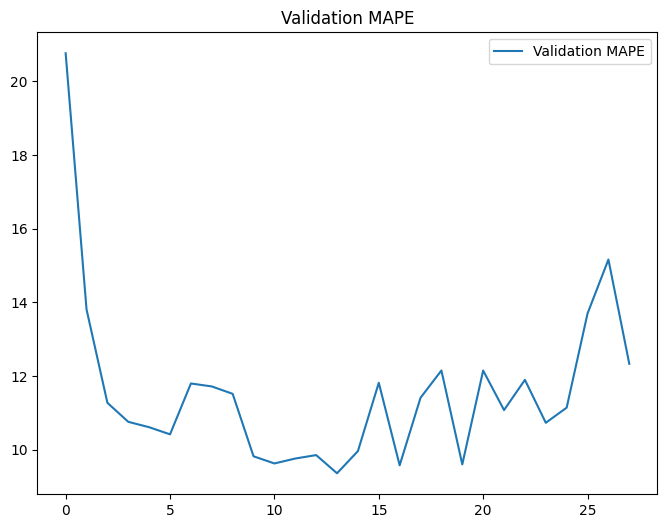

In [70]:
model_gru_w90h30_preds_inv, model_gru_w90h30_res = fit_eval(model_gru, horizon=30, window=90)
model_gru_w90h30_res

In [71]:
# Compile all results together
model_gru_res = {
    "W7H1": model_gru_w7h1_res,
    "W7H7": model_gru_w7h7_res,
    "W30H1": model_gru_w30h1_res,
    "W30H7": model_gru_w30h7_res,
    "W90H1": model_gru_w90h1_res,
    "W90H7": model_gru_w90h7_res,
    "W90H30": model_gru_w90h30_res,
}

In [92]:
all_res["GRU"] = model_gru_res

### Bidirectional GRU (Gated Recurrent Unit)

In [73]:
model_bi_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(16, activation="relu"))
], name="BiGRU")


#### BiGRU - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 72.
Epoch 80: early stopping

--------------------
Evaluating model on test data...
[0.009072600863873959, 0.009072600863873959, 0.00021133199334144592, 2.1009109020233154]
22/22 [==============================] - 0s 2ms/step


{'mae': 661.4416, 'mse': 1123271.4, 'rmse': 661.4416, 'mape': 2.0869715}

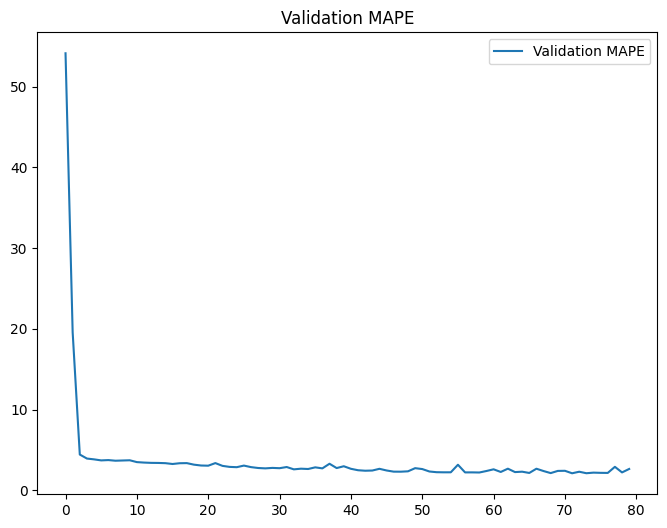

In [74]:
model_bi_gru_w7h1_preds_inv, model_bi_gru_w7h1_res = fit_eval(model_bi_gru, horizon=1, window=7)
model_bi_gru_w7h1_res

#### BiGRU - Window Size 7, Horizon 7


--------------------
Evaluating model on test data...
[0.017346976324915886, 0.017346976324915886, 0.0007680142298340797, 4.13220739364624]
22/22 [==============================] - 0s 1ms/step


{'mae': 1264.6881, 'mse': 4082146.5, 'rmse': 1264.6881, 'mape': 4.1042495}

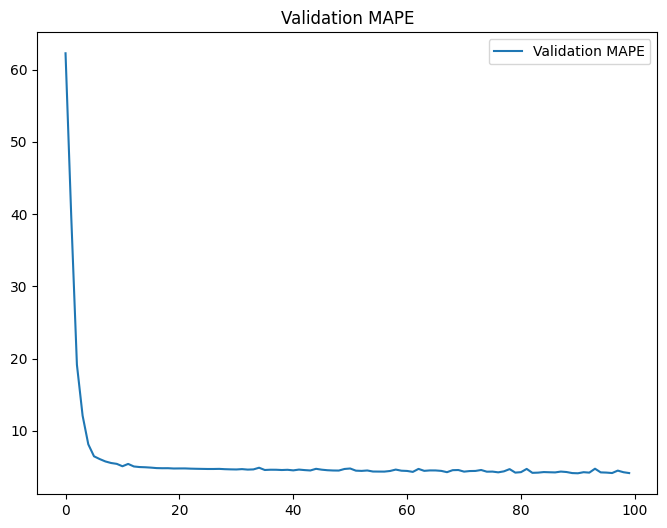

In [75]:
model_bi_gru_w7h7_preds_inv, model_bi_gru_w7h7_res = fit_eval(model_bi_gru, horizon=7, window=7)
model_bi_gru_w7h7_res

#### BiGRU - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 55.
Epoch 63: early stopping

--------------------
Evaluating model on test data...
[0.010800899937748909, 0.010800899937748909, 0.0002835013438016176, 2.590568780899048]
22/22 [==============================] - 0s 2ms/step


{'mae': 787.4439, 'mse': 1506865.6, 'rmse': 787.4439, 'mape': 2.5729291}

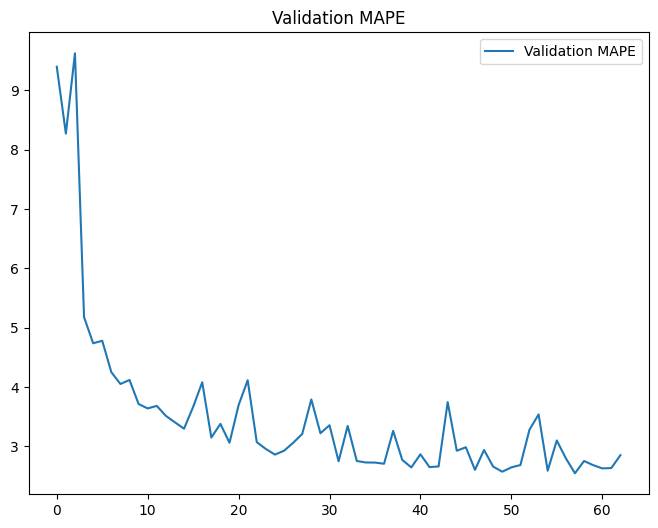

In [76]:
model_bi_gru_w30h1_preds_inv, model_bi_gru_w30h1_res = fit_eval(model_bi_gru, horizon=1, window=30)
model_bi_gru_w30h1_res

#### BiGRU - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 45.
Epoch 53: early stopping

--------------------
Evaluating model on test data...
[0.019722577184438705, 0.019722577184438705, 0.0009276082855649292, 4.755904197692871]
22/22 [==============================] - 1s 2ms/step


{'mae': 1437.8822, 'mse': 4930421.0, 'rmse': 1437.8822, 'mape': 4.7233896}

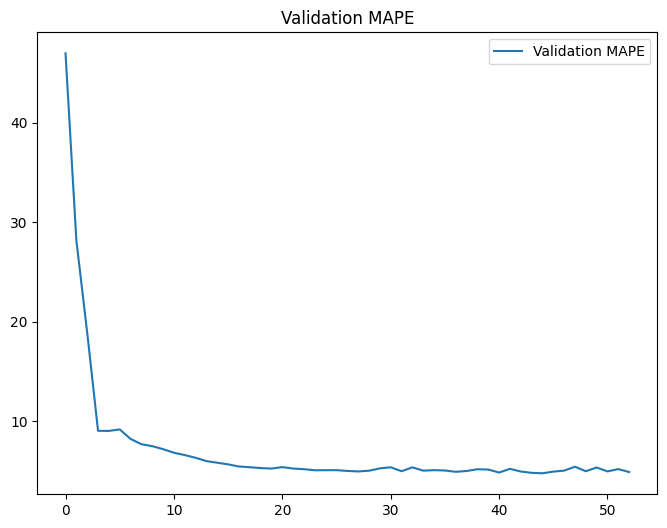

In [77]:
model_bi_gru_w30h7_preds_inv, model_bi_gru_w30h7_res = fit_eval(model_bi_gru, horizon=7, window=30)
model_bi_gru_w30h7_res

#### BiGRU - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 38.
Epoch 46: early stopping

--------------------
Evaluating model on test data...
[0.012511511333286762, 0.012511511333286762, 0.0003519837337080389, 3.056286096572876]
22/22 [==============================] - 0s 1ms/step


{'mae': 912.15674, 'mse': 1870862.8, 'rmse': 912.15674, 'mape': 3.0351455}

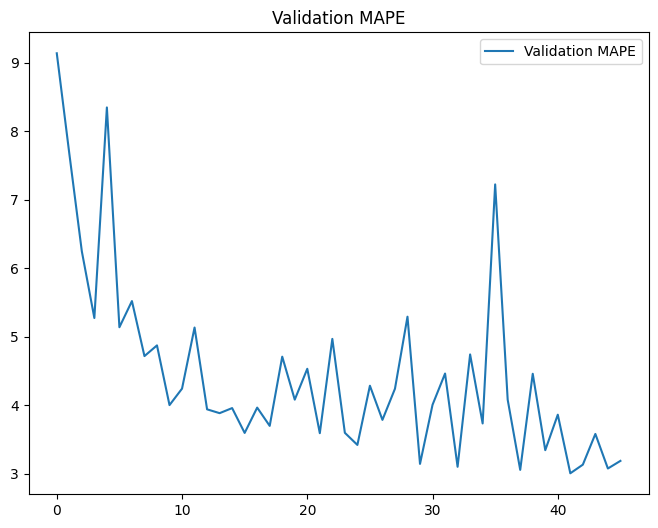

In [78]:
model_bi_gru_w90h1_preds_inv, model_bi_gru_w90h1_res = fit_eval(model_bi_gru, horizon=1, window=90)
model_bi_gru_w90h1_res

#### BiGRU - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 28.
Epoch 36: early stopping

--------------------
Evaluating model on test data...
[0.021143559366464615, 0.021143559366464615, 0.0010131507879123092, 5.180371284484863]
22/22 [==============================] - 0s 2ms/step


{'mae': 1541.4795, 'mse': 5385096.5, 'rmse': 1541.4795, 'mape': 5.1444874}

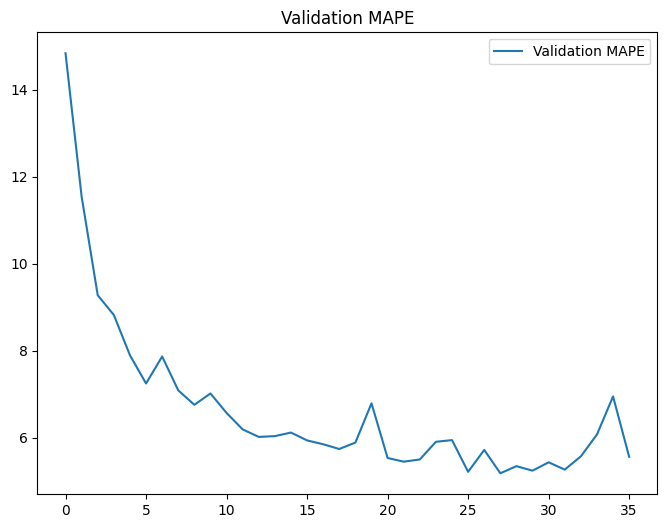

In [79]:
model_bi_gru_w90h7_preds_inv, model_bi_gru_w90h7_res = fit_eval(model_bi_gru, horizon=7, window=90)
model_bi_gru_w90h7_res

#### BiGRU - Window Size 90, Horizon 30


Restoring model weights from the end of the best epoch: 42.
Epoch 50: early stopping

--------------------
Evaluating model on test data...
[0.041102174669504166, 0.041102174669504166, 0.004256774205714464, 9.904677391052246]
22/22 [==============================] - 0s 1ms/step


{'mae': 2996.57, 'mse': 22625592.0, 'rmse': 2996.57, 'mape': 9.836211}

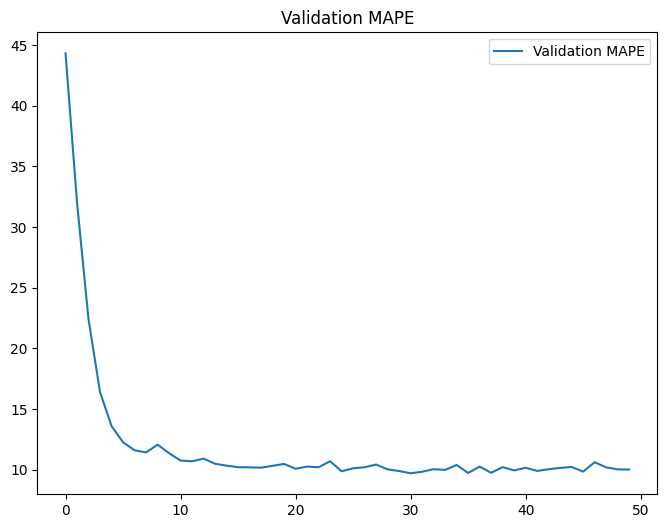

In [80]:
model_bi_gru_w90h30_preds_inv, model_bi_gru_w90h30_res = fit_eval(model_bi_gru, horizon=30, window=90)
model_bi_gru_w90h30_res

In [81]:
# Compile all results together
model_bi_gru_res = {
    "W7H1": model_bi_gru_w7h1_res,
    "W7H7": model_bi_gru_w7h7_res,
    "W30H1": model_bi_gru_w30h1_res,
    "W30H7": model_bi_gru_w30h7_res,
    "W90H1": model_bi_gru_w90h1_res,
    "W90H7": model_bi_gru_w90h7_res,
    "W90H30": model_bi_gru_w90h30_res,
}

In [93]:
all_res["BiGRU"] = model_bi_gru_res

## Evaluating Models

In [94]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame.from_dict({(i, j): all_res[i][j]
                                  for i in all_res.keys()
                                  for j in all_res[i].keys()},
                                 orient='columns').transpose())

                       mae           mse         rmse       mape
FNN    W7H1     628.712158  1.034193e+06   628.712158   1.982863
       W7H7    1234.659668  3.875599e+06  1234.659668   4.010723
       W30H1    649.839294  1.076858e+06   649.839294   2.121557
       W30H7   1290.087646  4.149560e+06  1290.087646   4.197785
       W90H1   1025.768677  2.397259e+06  1025.768677   3.393787
       W90H7   1576.701904  5.447342e+06  1576.701904   5.259421
       W90H30  2911.281494  2.069335e+07  2911.281494   9.490272
Conv1D W7H1     598.979980  9.829198e+05   598.979980   1.914350
       W7H7    1207.195557  3.813066e+06  1207.195557   3.916466
       W30H1    619.912598  1.026485e+06   619.912598   1.987105
       W30H7   1281.138306  4.129959e+06  1281.138306   4.158432
       W90H1    629.357666  1.086144e+06   629.357666   2.027360
       W90H7   1272.541504  4.271684e+06  1272.541504   4.074076
       W90H30  2565.979004  1.705203e+07  2565.979004   8.350821
LSTM   W7H1     664.69043

In [95]:
def plot_grouped(metric="mape", figsize=(10, 7)):
    """
    Plots a grouped bar chart of the evaluation metrics for each model. Each group represents a different window & horizon combination. Metric must be a valid key in the evaluation results dictionary.

    :param metric: str: the evaluation metric to plot, default "mape"
    :param figsize: tuple: the size of the plot, default (10, 7)
    :return: None
    """
    values = [["W7H1"], ["W7H7"], ["W30H1"], ["W30H7"], ["W90H1"], ["W90H7"], ["W90H30"]]
    for k, v in all_res.items():
        values[0].append(v["W7H1"][metric])
        values[1].append(v["W7H7"][metric])
        values[2].append(v["W30H1"][metric])
        values[3].append(v["W30H7"][metric])
        values[4].append(v["W90H1"][metric])
        values[5].append(v["W90H7"][metric])
        values[6].append(v["W90H30"][metric])

    columns = ['Windows & Horizons', *all_res.keys()]
    df = pd.DataFrame(values, columns=columns)

    df.plot(
        x='Windows & Horizons',
        kind='bar',
        stacked=False,
        title=f'{metric.upper()} Values for Different Models and Windows & Horizons',
        figsize=figsize
    )

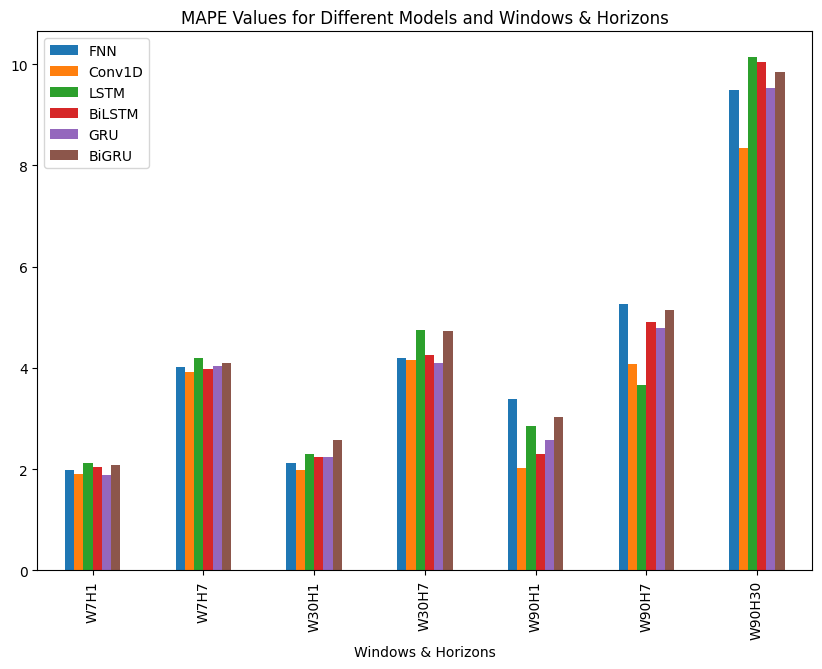

In [97]:
plot_grouped(metric='mape')